Notes:
* Final Logistic Regression model
* "Era" of fight
* Look into the fights that it judged wrongly - are they split dec? Any that are good?

In [1]:
# modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

df = pd.read_csv('every_ufc_fight_model_ready.csv')

In [2]:
filter_method = [
    'Decision - Unanimous',
    'Decision - Split',
    'Decision - Majority'
    ]

# select only decisions and 3 round fights
df_model = df[(df['method'].isin(filter_method)) & (df['number_of_rounds'] == 3)]

drop_cols = [
    'index',
    'date',
    'event_name',
    'first_fighter_name',
    'second_fighter_name',
    'method',
    'number_of_rounds'
    ]

df_model = df_model.drop(drop_cols, axis=1)
df_model = df_model.dropna(axis=1)

In [32]:
df_full = df_model.copy()

df_diff_first = df_model.filter(like='first').columns
df_diff_second = df_model.filter(like='second').columns

# create columns for the difference between first and second fighter stats
for index, value in enumerate(df_diff_first):
    base_col_name = df_diff_first[index].replace('first_fighter_', '')
    df_full[f'diff_{base_col_name}'] = df_full[df_diff_first[index]] - df_full[df_diff_second[index]]

In [33]:
def check_who_won(row, action):

    first_fighter_rounds_won = 0
    second_fighter_rounds_won = 0

    # Evaluate who won each round for the action and update counters
    for round_num in range(1, 4):
        if row[f'first_fighter_round_{round_num}_{action}'] > row[f'second_fighter_round_{round_num}_{action}']:
            first_fighter_rounds_won += 1
        elif row[f'first_fighter_round_{round_num}_{action}'] < row[f'second_fighter_round_{round_num}_{action}']:
            second_fighter_rounds_won += 1

    if first_fighter_rounds_won > second_fighter_rounds_won:
        return 1
    else:
        return 0

cols_to_judge = [
    'SIG_STR_landed',
    'CTRL',
    'KD',
    'SUB',
    'REV',
    'TOT_STR_landed',
    'SIG_STR_attempted',
    'TOT_STR_attempted',
    'TD_landed',
    'TD_attempted',
    'HEAD_landed',
    'HEAD_attempted',
    'BODY_landed',
    'BODY_attempted',
    'LEG_landed',
    'LEG_attempted',
]
for action in cols_to_judge:  # Add more action types as needed
    df_full[f'first_fighter_more_rounds_{action}'] = df_full.apply(lambda row: check_who_won(row, action), axis=1)

In [34]:
# Normalize the data
columns_to_scale = df_full.columns.drop('winner')
scaler = StandardScaler()
df_full[columns_to_scale] = scaler.fit_transform(df_full[columns_to_scale])

X = df_full.drop('winner', axis=1)
y = df_full['winner'].astype('category')

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the model
model = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')
model.fit(X_train, y_train)

# Testing the model
y_pred = model.predict(X_test)

# Evaluating the model
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score: ", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8261589403973509
Precision: 0.8375796178343949
Recall: 0.8296529968454258
F1 Score:  0.8335974643423139


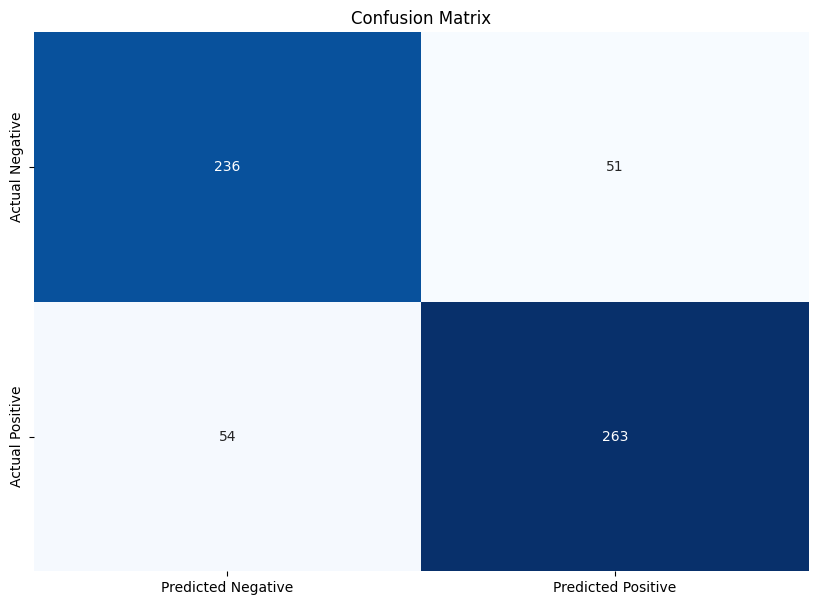

In [35]:
# Generate and print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
# Convert confusion matrix to a dataframe for better visualization
cm_df = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'],
                     index=['Actual Negative', 'Actual Positive'])

# Plot the heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.show()

In [36]:
odds_ratios = model.coef_

coef_df = pd.DataFrame({'features': X_train.columns, 'coef': odds_ratios[0]})
# Sort by coef value
coef_df = coef_df.sort_values('coef', ascending=False)

print(coef_df)

                                     features      coef
141                                  diff_STR  2.353350
142                                   diff_TD  1.076925
63   second_fighter_round_3_TOT_STR_attempted  0.432345
140                                   diff_KD  0.284841
88        first_fighter_round_1_GROUND_landed  0.265189
..                                        ...       ...
50      second_fighter_round_2_TOT_STR_landed -0.232491
148                           diff_round_2_KD -0.249368
78          second_fighter_round_1_LEG_landed -0.254738
15                second_fighter_round_1_CTRL -0.321092
89     first_fighter_round_1_GROUND_attempted -0.324926

[226 rows x 2 columns]


In [39]:
# df_join_cols = ['date', 'event_name', 'first_fighter_name', 'second_fighter_name', 'method']
# df_join = df[df_join_cols]


# Create a DataFrame from y_test
df_y_test = pd.DataFrame(y_test)

# Add a column for the predictions
df_y_test['prediction'] = y_pred

# Create a column for whether each prediction is correct
df_y_test['is_correct'] = df_y_test['winner'] == df_y_test['prediction']

# Filter to only incorrect predictions
df_incorrect = df_y_test[~df_y_test['is_correct']]

# Combine this with X_test to have the features as well
df_incorrect = df_incorrect.join(X_test, how='inner')

In [42]:
df_incorrect

,winner,prediction,is_correct,first_fighter_KD,second_fighter_KD,first_fighter_STR,second_fighter_STR,first_fighter_TD,second_fighter_TD,first_fighter_SUB,...,first_fighter_more_rounds_SIG_STR_attempted,first_fighter_more_rounds_TOT_STR_attempted,first_fighter_more_rounds_TD_landed,first_fighter_more_rounds_TD_attempted,first_fighter_more_rounds_HEAD_landed,first_fighter_more_rounds_HEAD_attempted,first_fighter_more_rounds_BODY_landed,first_fighter_more_rounds_BODY_attempted,first_fighter_more_rounds_LEG_landed,first_fighter_more_rounds_LEG_attempted
2707,1,0,False,-0.289956,-0.300725,-1.019668,0.076823,0.760059,0.720755,0.748681,...,-0.989777,1.01234,-0.785384,1.117201,-0.945469,-0.961305,-0.890299,-0.91754,-0.870723,-0.889701
460,0,1,False,-0.289956,-0.300725,0.073667,-0.348256,-0.763594,0.227890,0.748681,...,1.010328,1.01234,1.273263,1.117201,-0.945469,1.040253,1.123218,1.08987,-0.870723,-0.889701
3567,0,1,False,2.385262,-0.300725,-0.131333,-0.383679,-0.255710,1.706483,-0.432067,...,-0.989777,1.01234,1.273263,1.117201,-0.945469,-0.961305,1.123218,-0.91754,-0.870723,-0.889701
1040,0,1,False,-0.289956,-0.300725,-0.643834,0.005976,0.760059,-0.264974,1.929429,...,1.010328,-0.98781,-0.785384,-0.895094,1.057677,1.040253,-0.890299,-0.91754,1.148471,1.123973
1865,0,1,False,-0.289956,-0.300725,0.927835,0.360209,-0.255710,-0.757838,-0.432067,...,-0.989777,-0.98781,-0.785384,-0.895094,-0.945469,-0.961305,-0.890299,-0.91754,-0.870723,-0.889701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5932,1,0,False,-0.289956,-0.300725,-0.473000,-1.198414,-0.763594,2.692211,-0.432067,...,1.010328,1.01234,-0.785384,-0.895094,1.057677,1.040253,-0.890299,1.08987,1.148471,1.123973
18,1,0,False,-0.289956,-0.300725,0.586168,0.501902,-0.255710,-0.757838,-0.432067,...,-0.989777,-0.98781,-0.785384,1.117201,-0.945469,-0.961305,-0.890299,-0.91754,1.148471,1.123973
1539,0,1,False,-0.289956,2.306419,-0.541334,-0.277410,0.760059,-0.757838,-0.432067,...,-0.989777,1.01234,1.273263,1.117201,-0.945469,-0.961305,-0.890299,-0.91754,1.148471,1.123973
2705,0,1,False,-0.289956,-0.300725,-0.404667,-0.844181,-0.255710,0.720755,0.748681,...,-0.989777,-0.98781,1.273263,1.117201,-0.945469,-0.961305,-0.890299,-0.91754,-0.870723,-0.889701


In [43]:
# half are split decisions
df_incorrect_names = df.loc[df_incorrect.index]

In [49]:
df_incorrect_names.dropna(axis=1)['method'].value_counts()

method
Decision - Split        54
Decision - Unanimous    47
Decision - Majority      4
Name: count, dtype: int64

20% of fighter are split decisions, so haveing about 50/50 split shows that split decisions are really closer